<font size = 32>Expectativa de mortes</font>

# Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotnine as gg

import os
import sys
import re
from unidecode import unidecode
from functools import reduce
from itertools import product

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

sys.path.append("../src/")
from io_pyarrow.io_pyarrow import write_table_from_pandas, read_table_to_pandas

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext watermark
%watermark --iversion

re        : 2.2.1
pandas    : 1.3.5
plotnine  : 0.8.0
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.5.0
numpy     : 1.21.2



# Carregando arquivos xlsx

In [2]:
path = "../data/raw/Historico_obitos/"
meses = ["Janeiro","Fevereiro","Março","Abril","Maio","Junho","Julho","Agosto","Setembro","Outubro","Novembro","Dezembro"]

In [3]:
dict_arquivos_import = {mes: "".join(("obitos_",unidecode(mes).lower(),"_natural.xlsx")) for mes in meses}

In [4]:
def tratamento_planilha(nome_arquivo, sheet_name, path = path,filtra_SP=True):
    #Lendo o arquivo xlsx na aba "sheet_name"
    mortes_ano_raw = pd.read_excel(path + nome_arquivo,sheet_name=sheet_name,engine='openpyxl')
    
    #Coletando do nome da aba, as informações necessárias
    re_nome_planilha = re.search("(.*)(;)(.*)(;)(.*)(;)(.*)",sheet_name)
    ano = int(re_nome_planilha.group(3))
    mes = re_nome_planilha.group(5).strip()
    genero = re_nome_planilha.group(7).strip()
    print("Ano:",ano,"/ Mes:",mes,"/ Genero:",genero)

    #Tratatando o nome das colunas
    mortes_ano_tratado = mortes_ano_raw.iloc[5:,:]
    nome_colunas = ["Municipio","Idade","Local_Ocorrencia","Natureza_Obito","Qtd"]
    mortes_ano_tratado.columns = nome_colunas

    #Removendo a última linha do arquivo, que não tem relevancia
    mortes_ano_tratado = mortes_ano_tratado.iloc[:-1,:]

    #Removendo as colunas Local_Ocorrencia e Natureza_Obito, pois elas não são relevantes
    mortes_ano_tratado = mortes_ano_tratado.drop(columns = ["Local_Ocorrencia","Natureza_Obito"])

    #Inserindo as novas colunas com as informações de ano, mes e genero
    mortes_ano_tratado["Ano"] = ano
    mortes_ano_tratado["Mes"] = mes
    mortes_ano_tratado["Genero"] = genero

    #Convertendo a coluna Qtd em numerico
    mortes_ano_tratado.Qtd = mortes_ano_tratado.Qtd.replace("-","0").replace("...","0").astype(float)

    #Preenchendo os valores faltantes de municipios com os dados anteriores
    mortes_ano_tratado.Municipio = mortes_ano_tratado.Municipio.fillna(method='ffill')

    #Encontrando o estado de cada municipio
    mortes_ano_tratado["Cidade"] = mortes_ano_tratado.Municipio.\
                                    apply(lambda x: re.search("(.*)(\()([A-Z]{2})(\))",x).group(1))
    mortes_ano_tratado["Estado"] = mortes_ano_tratado.Municipio.\
                                    apply(lambda x: re.search("(.*)(\()([A-Z]{2})(\))",x).group(3))

    if filtra_SP:
        #Recuperando apenas as cidades de SP
        mortes_ano_tratado = mortes_ano_tratado.query("Estado == 'SP'")

    #Ordenando as colunas
    mortes_ano_tratado = mortes_ano_tratado[["Cidade","Estado","Ano","Mes","Genero","Idade","Qtd"]]

    return mortes_ano_tratado
    
def tratamento_xslx(nome_arquivo, path = path,filtra_SP = True):
    print("!!!",nome_arquivo)
    xlsx = pd.ExcelFile(path + nome_arquivo)
    nomes_planilhas = xlsx.sheet_names[:-1]
    mortes_ano_tratado = reduce(lambda x,y: pd.concat((x,y)), 
                                [tratamento_planilha(nome_arquivo, nome_plan, path,filtra_SP) 
                                 for nome_plan in nomes_planilhas])
    return mortes_ano_tratado

In [5]:
if "historico_obitos.parquet" in os.listdir("../data/interim/"):
    dados = read_table_to_pandas("../data/interim/historico_obitos.parquet")
else:
    dados = reduce(lambda x,y: pd.concat((x,y)),
                   [tratamento_xslx(dict_arquivos_import[mes]) for mes in meses]).reset_index(drop=True)
    dados.Mes = dados.Mes.replace({"Jan...": "01-01",
                                   "Fev...": "02-01",
                                   "Março" : "03-01",
                                   "Abril" : "04-01",
                                   "Maio"  : "05-01",
                                   "Junho" : "06-01",
                                   "Julho" : "07-01",
                                   "Agosto": "08-01",
                                   "Set...": "09-01",
                                   "Out...": "10-01",
                                   "Nov...": "11-01",
                                   "Dez...": "12-01"})
    dados["AnoMes"] = (dados.Ano.astype(str) + "-" + dados.Mes).astype("datetime64")
    dados = dados.drop(columns=["Ano","Mes"])
    dados = dados[["Cidade","Estado","AnoMes","Genero","Idade","Qtd"]]
    write_table_from_pandas(dados,"../data/interim/historico_obitos.parquet")

# Seleção das cidades estudadas

In [6]:
cidades_estudadas = ['ARUJA', 'BARUERI', 'BIRITIBA MIRIM', 'CAIEIRAS', 'CAJAMAR',
                       'CARAPICUIBA', 'COTIA', 'DIADEMA', 'EMBU DAS ARTES', 'EMBU-GUACU',
                       'FERRAZ DE VASCONCELOS', 'FRANCISCO MORATO', 'FRANCO DA ROCHA',
                       'GUARAREMA', 'GUARULHOS', 'ITAPECERICA DA SERRA', 'ITAPEVI',
                       'ITAQUAQUECETUBA', 'JANDIRA', 'JUQUITIBA', 'MAIRIPORA', 'MAUA',
                       'MOGI DAS CRUZES', 'OSASCO', 'PIRAPORA DO BOM JESUS', 'POA',
                       'RIBEIRAO PIRES', 'RIO GRANDE DA SERRA', 'SALESOPOLIS',
                       'SANTA ISABEL', 'SANTANA DE PARNAIBA', 'SANTO ANDRE',
                       'SAO BERNARDO DO CAMPO', 'SAO CAETANO DO SUL',
                       'SAO LOURENCO DA SERRA', 'SAO PAULO', 'SUZANO', 'TABOAO DA SERRA',
                       'VARGEM GRANDE PAULISTA']

In [7]:
# Os nomes das cidades do notebook 19 estão "unidecodadas" e maiusculas, portanto, devemos fazer o mesmo
dados["CidadeUnidecode"] = dados.Cidade.apply(lambda x: unidecode(x.upper().strip()))

In [8]:
dados2 = dados[dados.CidadeUnidecode.isin(cidades_estudadas)].drop(columns = "CidadeUnidecode")

# Ajuste da faixas de idade
Conforme o jupyter 19, existe um padrão para as faixas de idades. Vamos deixar este para se ajustar ao do jupyter

In [9]:
#Replicando a função de construção de faixa etária do jupyter 19
def constroi_faixa_etaria(b):
    fe = []
    for b0,b1 in zip(b,b[1:]):
        if b0 > 0:
            b_menor = b0 + 1
        else:
            b_menor = b0
        b_maior = b1
        
        if b_maior == np.inf:
            fe.append("%s anos ou mais" % (b_menor))
        else:
            fe.append("%s a %s anos"%(b_menor,b_maior))
    
    return fe

bins = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,np.inf]
faixa_etaria = constroi_faixa_etaria(bins)

In [10]:
dados2["Idade"] = dados2.Idade.replace({'Menos de 1 ano':'0 a 4 anos',
                                       '1 a 4 anos':'0 a 4 anos',
                                       '90 a 94 anos':'90 anos ou mais',
                                       '95 a 99 anos':'90 anos ou mais',
                                       '100 anos ou mais': '90 anos ou mais'})

In [11]:
#Verificando se algum valor ficou faltando a conversão
dados2.groupby(["Genero","Idade"])["Qtd"].sum().reset_index() \
      .assign(Idade = lambda x: pd.Categorical(x["Idade"],categories=faixa_etaria,ordered=True)).isna().sum().sum()

0

In [12]:
dados3 = dados2.groupby(["Cidade","AnoMes","Genero","Idade"]).Qtd.sum().reset_index()
dados3

,Cidade,AnoMes,Genero,Idade,Qtd
0,Arujá,2009-01-01,Homens,0 a 4 anos,0.0
1,Arujá,2009-01-01,Homens,10 a 14 anos,0.0
2,Arujá,2009-01-01,Homens,15 a 19 anos,0.0
3,Arujá,2009-01-01,Homens,20 a 24 anos,1.0
4,Arujá,2009-01-01,Homens,25 a 29 anos,0.0
...,...,...,...,...,...
213403,Vargem Grande Paulista,2020-12-01,Mul...,70 a 74 anos,2.0
213404,Vargem Grande Paulista,2020-12-01,Mul...,75 a 79 anos,3.0
213405,Vargem Grande Paulista,2020-12-01,Mul...,80 a 84 anos,0.0
213406,Vargem Grande Paulista,2020-12-01,Mul...,85 a 89 anos,0.0


# Vizualizando a primeira série temporal de óbitos
Vamos vizualizar os casos totais de óbitos ao longo dos anos

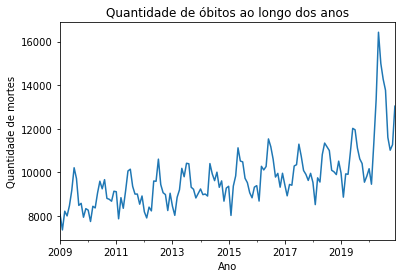

In [13]:
#Interessante notar que há um aumento nos casos de mortes (o que pode estar relacionado com o aumento da população mais velha)
#Mas também períodos de sazonalidade. Importante notar como 2020 o volume de mortes é muito maior
dados3.groupby("AnoMes").Qtd.sum().plot()
plt.title("Quantidade de óbitos ao longo dos anos")
plt.xlabel("Ano")
plt.ylabel("Quantidade de mortes");

In [14]:
#Como 2020 foi um ano atipico e é quem queremos calcular a expectativa de mortes, vamos desconsiderar da análise por enquanto
dados4 = dados3[dados3.AnoMes.dt.year < 2020]

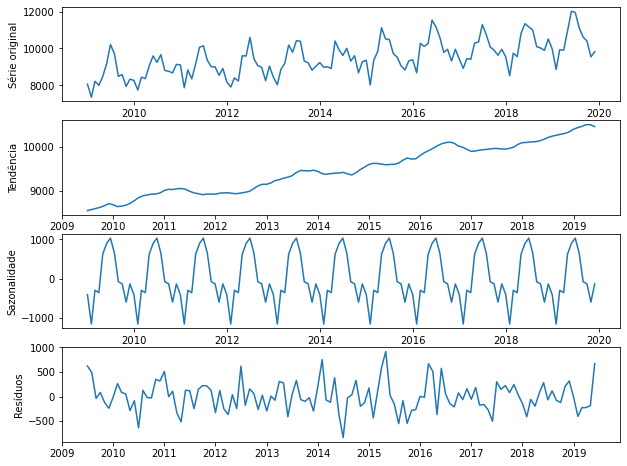

In [15]:
_,ax = plt.subplots(figsize = (10,8),nrows = 4)
ax = ax.flatten()
sd = seasonal_decompose(dados4.groupby("AnoMes").Qtd.sum())
ax[0].plot(sd.observed)
ax[0].set_ylabel("Série original")
ax[1].plot(sd.trend)
ax[1].set_ylabel("Tendência")
ax[2].plot(sd.seasonal)
ax[2].set_ylabel("Sazonalidade")
ax[3].plot(sd.resid)
ax[3].set_ylabel("Resíduos")
plt.show()

# Criando modelos para previsão

In [16]:
#Vamos criar uma função para que, dada uma série temporal, ele retorne os dados de treino e teste
def Train_Test_Time_Series(ts):
    #Considerando que nosso propósito, com base no jupyter 19, é chegar até o mes de abril-2021, precisamos saber gerar 1 ano
    #(2020) + 4 meses de 2021
    ts_treino = ts[ts.index < "2018-09-01"]
    ts_teste = ts[ts.index >= "2018-09-01"]
    return ts_treino, ts_teste

#E também vamos aplicar como métrica de avaliação de modelo o RMSE
def RMSE(y_true,y_pred):
    y_pred_c = y_pred.copy()
    y_pred_c = y_pred_c.fillna(250e6)
    return np.sqrt(mean_squared_error(y_true = y_true, y_pred = y_pred_c))

In [17]:
#Vamos aplicar alguns modelos de séries temporais e avaliar quais delas melhor se saem para tentar predizer o futuro
#A sazonalidade ao que tudo indica, é de 1 ano
def avalia_RMSE(model,ts_teste,previsao):
    ts_pred = model.fit().forecast(previsao)
    rmse = RMSE(y_true = ts_teste, y_pred = ts_pred)
    return rmse

def atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao,
                              initialization_method = None):
    if melhores_modelos[metodo_atual] is None:
            melhores_modelos[metodo_atual] = {"Modelo":model,"RMSE":avalia_RMSE(model,ts_teste,previsao)}
            if metodo_atual == 'HoltWinters':
                melhores_modelos[metodo_atual]["initialization_method"] = initialization_method
        
    elif melhores_modelos[metodo_atual]["RMSE"] > avalia_RMSE(model,ts_teste,previsao):
            melhores_modelos[metodo_atual]["Modelo"] = model
            melhores_modelos[metodo_atual]["RMSE"] = avalia_RMSE(model,ts_teste,previsao)
            
    return melhores_modelos
    
def grid_search_time_series(ts,sazonalidade = 12,verbose = 0,previsao = 16):
    ts_treino,ts_teste = Train_Test_Time_Series(ts)
    #     HoltWinters
    if verbose > 2:
        print("!! --------- HOLT WINTERS")
    metodo_atual = "HoltWinters"
    trend = ["add","mul",None]
    seasonal = [("add",sazonalidade),("mul",sazonalidade),(None,None)]
    initialization_method = ["heuristic","estimated"]
    use_boxcox = [True,False]
    melhores_modelos = {"HoltWinters":None, "ARIMA": None, "SARIMAX": None, "Theta": None}
    
    for t,s,im,ub in product(trend,seasonal,initialization_method,use_boxcox):
        s1 = s[0]
        s2 = s[1]
        model = ExponentialSmoothing(ts_treino,
                                     trend=t,
                                     seasonal=s1,
                                     seasonal_periods=s2,
                                     initialization_method = im,
                                     use_boxcox = ub)

        melhores_modelos = atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao=previsao,
                                                     initialization_method = im)

        
#     ARIMA
    if verbose > 2:
        print("!! --------- ARIMA")
    metodo_atual = "ARIMA"
    aa = auto_arima(ts_treino,
                   start_p=0, start_q=0,
                   error_action='ignore',
                   seasonal=False, d=None, trace=False,
                   suppress_warnings=True, 
                   stepwise=False)
    
    model = SARIMAX(ts_treino,order = aa.order,seasonal_order=(0,0,0,0))
    melhores_modelos = atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao = previsao)
        
#     SARIMAX
    if verbose > 2:
        print("!! --------- SARIMAX")
    metodo_atual = "SARIMAX"
    aa = auto_arima(ts_treino,
                       start_p=0, start_q=0,
                       start_P = 0, start_Q = 0, m =sazonalidade,
                       error_action='ignore',
                       seasonal=True, d=None, trace=False,
                       suppress_warnings=True, 
                       stepwise=False)

    model = SARIMAX(ts_treino,order = aa.order, seasonal_order = aa.seasonal_order, initialization = 'approximate_diffuse')
    melhores_modelos = atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao=previsao)
        

#     Theta
    if verbose > 2:
        print("!! --------- THETA")
    metodo_atual = "Theta"
    model = ThetaModel(ts_treino,
                       deseasonalize=True,
                       period = sazonalidade)
    melhores_modelos = atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao=previsao)
    
    
    return melhores_modelos

def melhor_previsao(df,gen,idade,sazonalidade = 12,verbose = 0,show_result = False,previsao = 16):
    
    aux_ts = df.query("Genero == '%s' & Idade == '%s'"%(gen,idade)).groupby("AnoMes").Qtd.sum().asfreq("MS")
    if verbose>0:
        print("\n**************************")
        print("Genero:",gen,"/ idade:",idade)
        
    resultado = grid_search_time_series(aux_ts,sazonalidade,verbose,previsao)
    melhor_modelo = list(resultado.keys())[np.argmin([resultado[r]["RMSE"] for r in resultado.keys()])]
    
    if melhor_modelo == 'HoltWinters':
        initialization_method = resultado[melhor_modelo]["initialization_method"]
        trend = resultado[melhor_modelo]["Modelo"].trend
        seasonal = resultado[melhor_modelo]["Modelo"].seasonal
        seasonal_periods = resultado[melhor_modelo]["Modelo"].seasonal_periods
        use_boxcox = resultado[melhor_modelo]["Modelo"].params["use_boxcox"]
        if verbose:
            print("**Melhor modelo: HoltWinters, tendencia:",trend, "/ seasonal:",seasonal,
                  "\ninitializarion_method: ", initialization_method, "/ use_boxcox:",use_boxcox)
        model = ExponentialSmoothing(aux_ts,
                                     trend=trend,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods,
                                     initialization_method = initialization_method,
                                     use_boxcox = use_boxcox).fit()
    elif melhor_modelo == 'ARIMA':
        pdq = resultado[melhor_modelo]["Modelo"].order
        if verbose>0:
            print("**Melhor modelo: ARIMA, (p,d,q):",pdq)
            
        model = SARIMAX(aux_ts,order = pdq,seasonal_order=(0,0,0,0)).fit()

    elif melhor_modelo == 'SARIMAX':
        pdq = resultado[melhor_modelo]["Modelo"].order
        PDQs = resultado[melhor_modelo]["Modelo"].seasonal_order
        
        if verbose>0:
            print("**Melhor modelo: SARIMAX, (p,d,q):",pdq, "/ (P,D,Q,s):",PDQs)
            
        #podemos encontrar alguns erros de algebra linear, portanto, vamos alterar o metodo de inicialização    
        model = SARIMAX(aux_ts,order = pdq,seasonal_order=PDQs, initialization = 'approximate_diffuse').fit()
    else:
        deseasonalize = resultado[melhor_modelo]["Modelo"].deseasonalize
        if verbose>0:
            print("**Melhor modelo: Theta")
        model = ThetaModel(aux_ts,deseasonalize=True,period=sazonalidade).fit()
    
    if show_result:
        _,ax = plt.subplots(figsize = (10,8))
        ax.plot(aux_ts)
        ax.plot(model.forecast(previsao))
        
    if verbose>0:
        print("##Melhores resultados (RMSE)##")
        print({k:round(resultado[k]["RMSE"],2) for k in resultado.keys()})
    
    return model.forecast(previsao)

def concat_forcast_info(df,sazonalidade = 12,verbose = 0,show_result = False,previsao = 16):
    lista_ts = []
    combinacoes_genero_idade = df[["Genero","Idade"]].drop_duplicates().to_numpy()
    for comb in combinacoes_genero_idade:
        gen = comb[0]
        idade = comb[1]
        ts_forecast = melhor_previsao(df,gen,idade,sazonalidade,verbose,show_result,previsao)\
                                .to_frame().assign(Idade = idade, Genero = gen)\
                                .rename(columns = {0:"previsão"})
        lista_ts.append(ts_forecast)
    
    return reduce(lambda x,y: pd.concat((x,y)),lista_ts)
    

In [26]:
# resultado = grid_search_time_series(dados4.query("Idade == '0 a 4 anos' & Genero == 'Homens'")\
#                                           .groupby("AnoMes").Qtd.sum().asfreq("MS"),
#                                     show_result = True)

In [32]:
resultado = concat_forcast_info(dados4,verbose=1)
# result = {}
# comb_genero_idade = dados4[["Genero","Idade"]].drop_duplicates().to_numpy()
# for comb in comb_genero_idade:
#     gen = comb[0]
#     idade = comb[1]
#     print("\n**************************")
#     print("Genero:",gen,"/ idade:",idade)
#     aux_df = dados4.query("Genero == '%s' & Idade == '%s'"%(gen,idade)).groupby("AnoMes").Qtd.sum().asfreq("MS")
#     result[gen + "_" + idade] = grid_search_time_series(aux_df,12,1,16)
#     print({k:round(result[gen + "_" + idade][k]["RMSE"],2) for k in result[gen + "_" + idade].keys()})


**************************
Genero: Homens / idade: 0 a 4 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 15.24, 'ARIMA': 18.22, 'SARIMAX': 15.63, 'Theta': 16.45}

**************************
Genero: Homens / idade: 10 a 14 anos
**Melhor modelo: HoltWinters, tendencia: None / seasonal: None 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 2.5, 'ARIMA': 2.62, 'SARIMAX': 2.51, 'Theta': 2.53}

**************************
Genero: Homens / idade: 15 a 19 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 5.83, 'ARIMA': 6.94, 'SARIMAX': 6.81, 'Theta': 6.61}

**************************
Genero: Homens / idade: 20 a 24 anos
**Melhor modelo: Theta
##Melhores resultados (RMSE)##
{'HoltWinters': 8.78, 'ARIMA': 10.4

**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: True
##Melhores resultados (RMSE)##
{'HoltWinters': 30.19, 'ARIMA': 36.8, 'SARIMAX': 37.32, 'Theta': 40.04}

**************************
Genero: Mul... / idade: 65 a 69 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 23.53, 'ARIMA': 43.24, 'SARIMAX': 29.48, 'Theta': 28.95}

**************************
Genero: Mul... / idade: 70 a 74 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 26.73, 'ARIMA': 41.93, 'SARIMAX': 27.85, 'Theta': 29.98}

**************************
Genero: Mul... / idade: 75 a 79 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##


In [34]:
resFinal = resultado.fillna(0).assign(previsao = lambda x: x["previsão"] + x["forecast"] + x["predicted_mean"]).reset_index()\
                .rename(columns = {"index":"AnoMes"})

In [36]:
comparacao_resultados = dados3.groupby(["Genero","Idade","AnoMes"]).Qtd.sum().reset_index() \
                            .merge(resFinal[["AnoMes","Idade","Genero","previsao"]],
                                   on = ["AnoMes","Idade","Genero"],
                                   how = 'outer')

In [37]:
comparacao_resultados.Genero = comparacao_resultados.Genero.replace({"Mul...":"Mulheres"})

In [47]:
comparacao_resultados

,Genero,Idade,AnoMes,Qtd,previsao
0,Homens,0 a 4 anos,2009-01-01,176.0,NaN
1,Homens,0 a 4 anos,2009-02-01,157.0,NaN
2,Homens,0 a 4 anos,2009-03-01,181.0,NaN
3,Homens,0 a 4 anos,2009-04-01,203.0,NaN
4,Homens,0 a 4 anos,2009-05-01,187.0,NaN
...,...,...,...,...,...
5619,Mulheres,85 a 89 anos,2021-04-01,NaN,615.684800
5620,Mulheres,90 anos ou mais,2021-01-01,NaN,785.342225
5621,Mulheres,90 anos ou mais,2021-02-01,NaN,745.588792
5622,Mulheres,90 anos ou mais,2021-03-01,NaN,788.310506


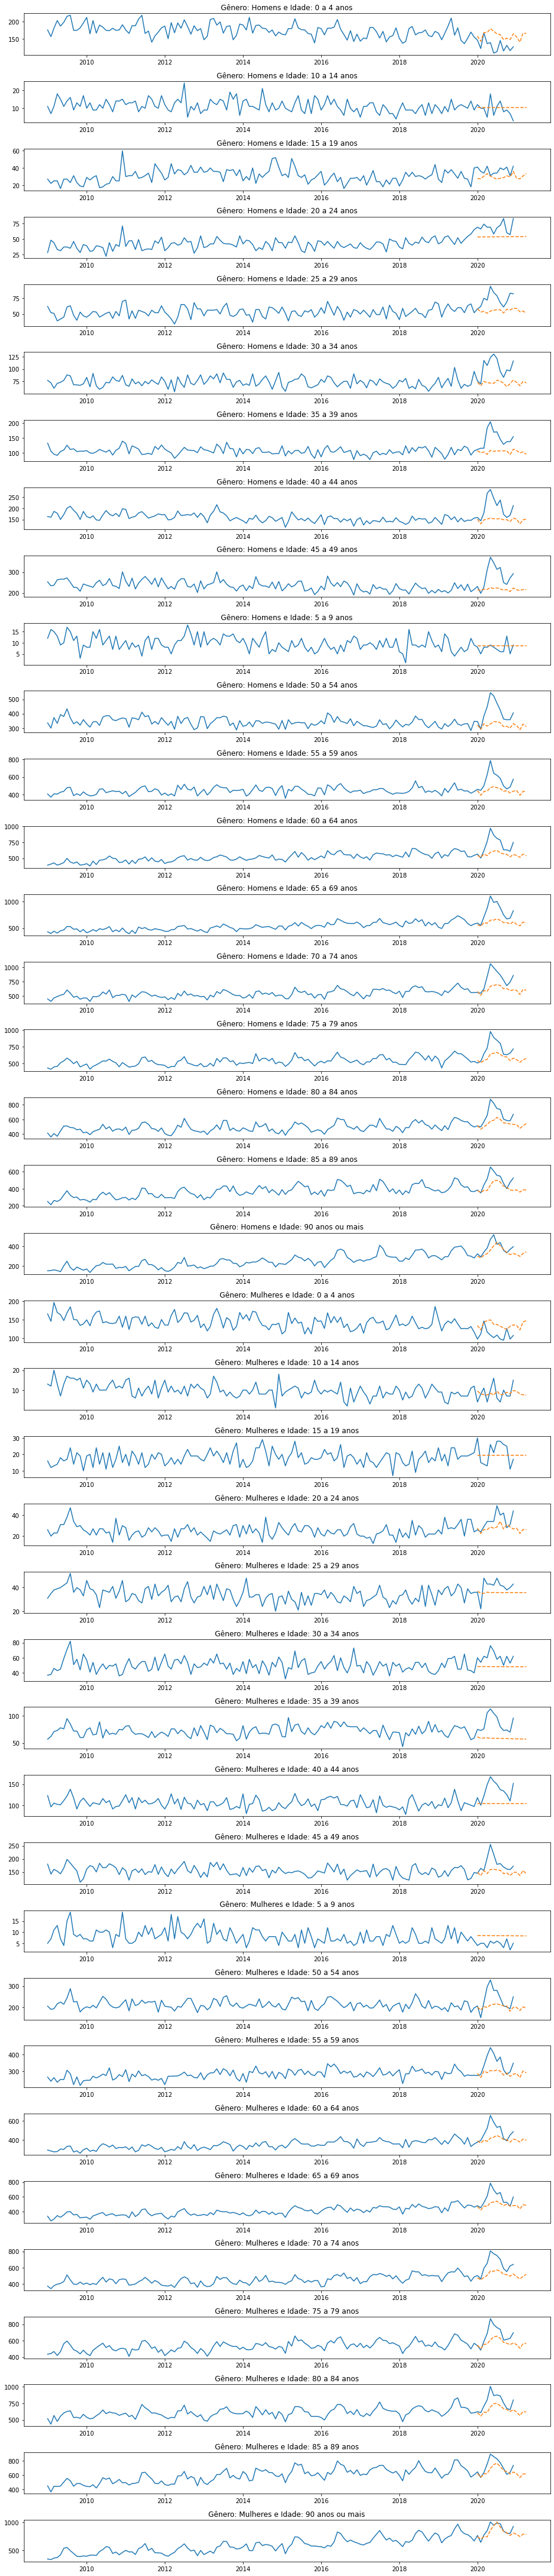

In [49]:
todas_combinacoes = comparacao_resultados[["Genero","Idade"]].drop_duplicates().to_numpy()
_,ax = plt.subplots(nrows = todas_combinacoes.shape[0], figsize = (13,60))
ax = ax.flatten()
for i,comb in enumerate(todas_combinacoes):
    df_aux = comparacao_resultados.query("Genero == '%s' & Idade == '%s'" % (comb[0], comb[1]))
    df_aux = df_aux.set_index("AnoMes")
    ax[i].plot(df_aux.Qtd)
    ax[i].plot(df_aux.previsao,linestyle = '--')
    ax[i].set_title("Gênero: %s e Idade: %s" %(comb[0], comb[1]))
plt.tight_layout()
plt.show()

In [198]:
comparacao_resultados.to_csv("../data/interim/expectativa_mortes.csv")

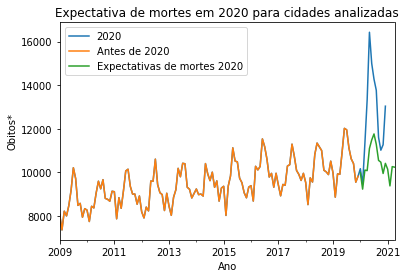

*óbitos por causas naturais


In [193]:
dados3.groupby("AnoMes").Qtd.sum().plot()
dados4.groupby("AnoMes").Qtd.sum().plot()
resFinal.pipe(lambda x: x[x.AnoMes.dt.year >= 2020]).groupby("AnoMes").previsao.sum().plot()
plt.xlabel("Ano")
plt.ylabel("Obitos*")
plt.legend(["2020","Antes de 2020","Expectativas de mortes 2020"])
plt.title("Expectativa de mortes em 2020 para cidades analizadas")
plt.show()

print("*óbitos por causas naturais")

In [194]:
resFinal.pipe(lambda x: x[x.AnoMes.dt.year >= 2020]).groupby("AnoMes").previsao.sum()

AnoMes
2020-01-01     9990.884680
2020-02-01     9231.888979
2020-03-01    10105.733761
2020-04-01    10081.224179
2020-05-01    11097.611357
2020-06-01    11489.307482
2020-07-01    11764.679853
2020-08-01    11288.573393
2020-09-01    10551.075008
2020-10-01    10469.281530
2020-11-01     9950.026371
2020-12-01    10414.983186
2021-01-01    10145.265137
2021-02-01     9380.122449
2021-03-01    10265.943488
2021-04-01    10240.967973
Name: previsao, dtype: float64

# Apenas HoltWinters

Visando uma modelagem mais simples, pelos testes realizados, o modelo de HoltWinters obteve resultados bem satisfatórios em todos os conjuntos de idade e gênero. Portanto, visando simplificar o resultado usando um único método, mas com modelos diferentes, afinal, cada série tem sua peculiaridade, vamos considerar apenas um Grid Search pelo método de HoltWinters

In [18]:
def grid_search_time_series_HoltWinters(ts,sazonalidade = 12,verbose = 0,previsao = 16):
    ts_treino,ts_teste = Train_Test_Time_Series(ts)
    #     HoltWinters
    if verbose > 2:
        print("!! --------- HOLT WINTERS")
    metodo_atual = "HoltWinters"
    trend = ["add","mul",None]
    seasonal = [("add",sazonalidade),("mul",sazonalidade),(None,None)]
    initialization_method = ["heuristic","estimated"]
    use_boxcox = [True,False]
    melhores_modelos = {"HoltWinters":None}
    
    for t,s,im,ub in product(trend,seasonal,initialization_method,use_boxcox):
        s1 = s[0]
        s2 = s[1]
        model = ExponentialSmoothing(ts_treino,
                                     trend=t,
                                     seasonal=s1,
                                     seasonal_periods=s2,
                                     initialization_method = im,
                                     use_boxcox = ub)

        melhores_modelos = atualiza_melhores_modelos(melhores_modelos,metodo_atual,model,ts_teste,previsao=previsao,
                                                     initialization_method = im)
   
    
    return melhores_modelos

def melhor_previsao_HoltWinters(df,gen,idade,sazonalidade = 12,verbose = 0,show_result = False,previsao = 16):
    
    aux_ts = df.query("Genero == '%s' & Idade == '%s'"%(gen,idade)).groupby("AnoMes").Qtd.sum().asfreq("MS")
    if verbose>0:
        print("\n**************************")
        print("Genero:",gen,"/ idade:",idade)
        
    resultado = grid_search_time_series_HoltWinters(aux_ts,sazonalidade,verbose,previsao)
    melhor_modelo = list(resultado.keys())[np.argmin([resultado[r]["RMSE"] for r in resultado.keys()])]
    
    
    initialization_method = resultado[melhor_modelo]["initialization_method"]
    trend = resultado[melhor_modelo]["Modelo"].trend
    seasonal = resultado[melhor_modelo]["Modelo"].seasonal
    seasonal_periods = resultado[melhor_modelo]["Modelo"].seasonal_periods
    use_boxcox = resultado[melhor_modelo]["Modelo"].params["use_boxcox"]
    if verbose:
        print("**Melhor modelo: HoltWinters, tendencia:",trend, "/ seasonal:",seasonal,
              "\ninitializarion_method: ", initialization_method, "/ use_boxcox:",use_boxcox)
    model = ExponentialSmoothing(aux_ts,
                                 trend=trend,
                                 seasonal=seasonal,
                                 seasonal_periods=seasonal_periods,
                                 initialization_method = initialization_method,
                                 use_boxcox = use_boxcox).fit()
    
    
    if show_result:
        _,ax = plt.subplots(figsize = (10,8))
        ax.plot(aux_ts)
        ax.plot(model.forecast(previsao))
        
    if verbose>0:
        print("##Melhores resultados (RMSE)##")
        print({k:round(resultado[k]["RMSE"],2) for k in resultado.keys()})
    
    return model.forecast(previsao)

def concat_forcast_info_HoltWinters(df,sazonalidade = 12,verbose = 0,show_result = False,previsao = 16):
    lista_ts = []
    combinacoes_genero_idade = df[["Genero","Idade"]].drop_duplicates().to_numpy()
    for comb in combinacoes_genero_idade:
        gen = comb[0]
        idade = comb[1]
        ts_forecast = melhor_previsao_HoltWinters(df,gen,idade,sazonalidade,verbose,show_result,previsao)\
                                .to_frame().assign(Idade = idade, Genero = gen)\
                                .rename(columns = {0:"previsão"})
        lista_ts.append(ts_forecast)
    
    return reduce(lambda x,y: pd.concat((x,y)),lista_ts)

In [20]:
resultado = concat_forcast_info_HoltWinters(dados4,verbose=1)


**************************
Genero: Homens / idade: 0 a 4 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 15.24}

**************************
Genero: Homens / idade: 10 a 14 anos
**Melhor modelo: HoltWinters, tendencia: None / seasonal: None 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 2.5}

**************************
Genero: Homens / idade: 15 a 19 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 5.83}

**************************
Genero: Homens / idade: 20 a 24 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: add 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 8.78}

**************************
Genero: Homens / idade: 25 a 29 anos

**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: True
##Melhores resultados (RMSE)##
{'HoltWinters': 41.42}

**************************
Genero: Mul... / idade: 85 a 89 anos
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: True
##Melhores resultados (RMSE)##
{'HoltWinters': 33.85}

**************************
Genero: Mul... / idade: 90 anos ou mais
**Melhor modelo: HoltWinters, tendencia: mul / seasonal: mul 
initializarion_method:  heuristic / use_boxcox: False
##Melhores resultados (RMSE)##
{'HoltWinters': 53.03}


In [22]:
resultado

,previsão,Idade,Genero
2020-01-01,158.406261,0 a 4 anos,Homens
2020-02-01,143.693774,0 a 4 anos,Homens
2020-03-01,168.481768,0 a 4 anos,Homens
2020-04-01,168.853420,0 a 4 anos,Homens
2020-05-01,179.476636,0 a 4 anos,Homens
...,...,...,...
2020-12-01,810.810470,90 anos ou mais,Mul...
2021-01-01,785.342225,90 anos ou mais,Mul...
2021-02-01,745.588792,90 anos ou mais,Mul...
2021-03-01,788.310506,90 anos ou mais,Mul...


In [27]:
resFinal = resultado.fillna(0).reset_index().rename(columns = {"index":"AnoMes","previsão":"previsao"})

In [29]:
comparacao_resultados = dados3.groupby(["Genero","Idade","AnoMes"]).Qtd.sum().reset_index() \
                            .merge(resFinal[["AnoMes","Idade","Genero","previsao"]],
                                   on = ["AnoMes","Idade","Genero"],
                                   how = 'outer')

In [30]:
comparacao_resultados.Genero = comparacao_resultados.Genero.replace({"Mul...":"Mulheres"})

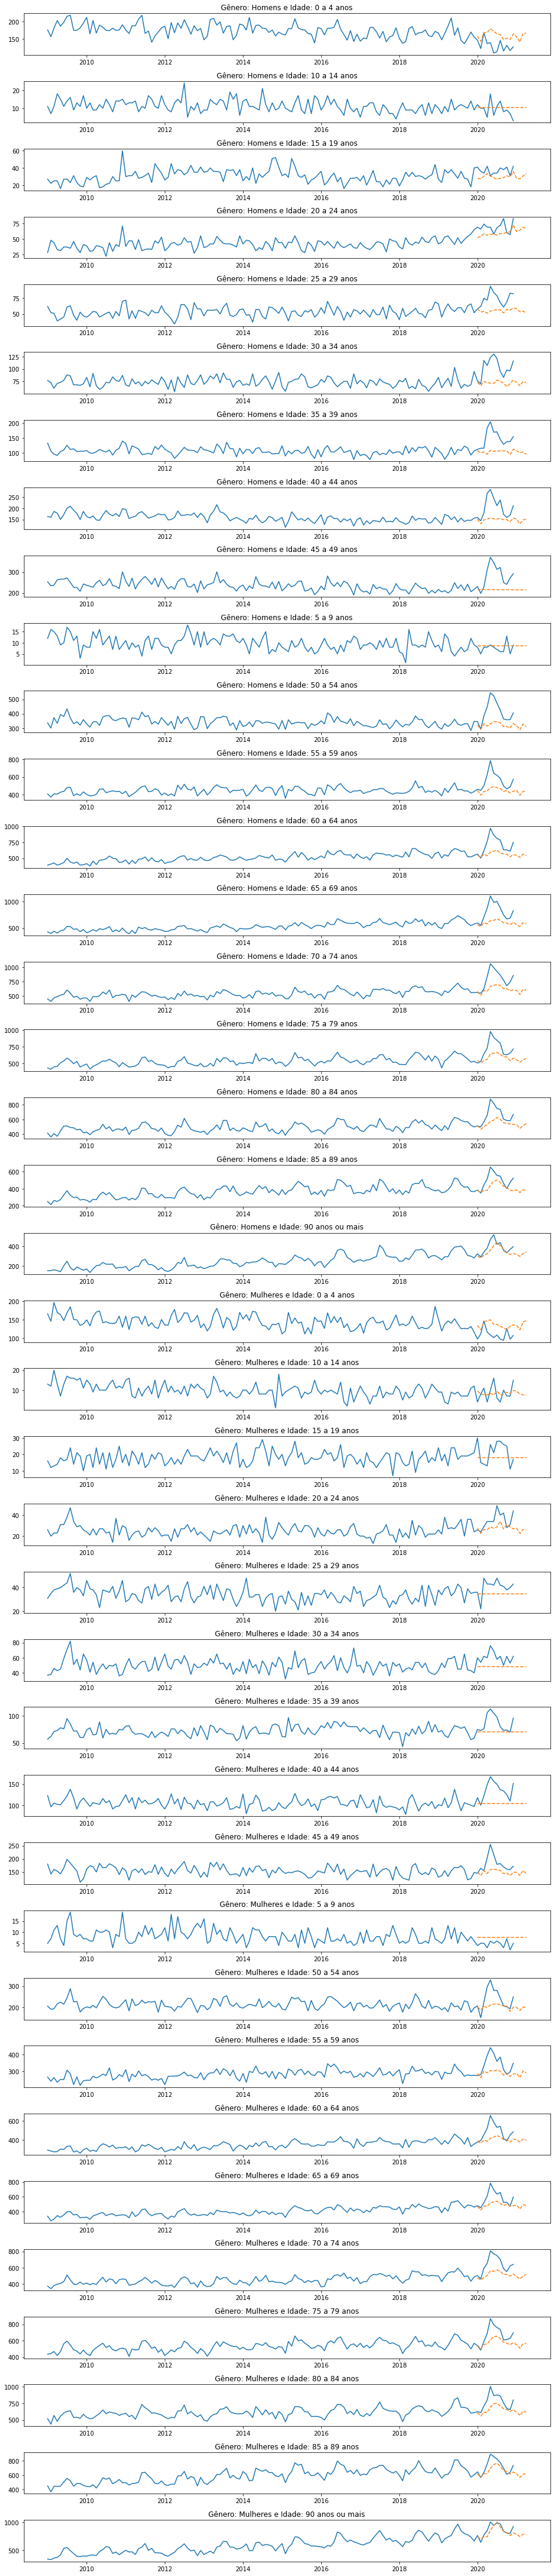

In [31]:
todas_combinacoes = comparacao_resultados[["Genero","Idade"]].drop_duplicates().to_numpy()
_,ax = plt.subplots(nrows = todas_combinacoes.shape[0], figsize = (13,60))
ax = ax.flatten()
for i,comb in enumerate(todas_combinacoes):
    df_aux = comparacao_resultados.query("Genero == '%s' & Idade == '%s'" % (comb[0], comb[1]))
    df_aux = df_aux.set_index("AnoMes")
    ax[i].plot(df_aux.Qtd)
    ax[i].plot(df_aux.previsao,linestyle = '--')
    ax[i].set_title("Gênero: %s e Idade: %s" %(comb[0], comb[1]))
plt.tight_layout()
plt.show()

In [32]:
comparacao_resultados.to_csv("../data/interim/expectativa_mortes_HoltWinters.csv")

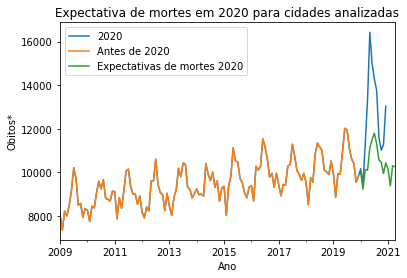

*óbitos por causas naturais


In [33]:
dados3.groupby("AnoMes").Qtd.sum().plot()
dados4.groupby("AnoMes").Qtd.sum().plot()
resFinal.pipe(lambda x: x[x.AnoMes.dt.year >= 2020]).groupby("AnoMes").previsao.sum().plot()
plt.xlabel("Ano")
plt.ylabel("Obitos*")
plt.legend(["2020","Antes de 2020","Expectativas de mortes 2020"])
plt.title("Expectativa de mortes em 2020 para cidades analizadas")
plt.show()

print("*óbitos por causas naturais")